In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import string
from PyPDF2 import PdfReader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multidict as multidict
from collections import defaultdict

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# python -m nltk.downloader stopwords
# python -m nltk.downloader wordnet

In [3]:
# Crear un campo que incluya el indice del articulo que incluye las palabras
# Hacer skip de las palabras utilizadas en los criterios de búsqueda
def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove trailing spaces and convert to lowercase
    text = text.strip().lower()
    
    # Remove stop words, custom ignore words, and words with length <= 3
    stop_words = set(stopwords.words('english'))
    ignore_words = set(['two', 'one', 'httpsdoiorgsx', 'york', 'callsystem', 'softw', 'acm', 'others', 'author', 'paper', 'related', 'international', 'conference', 'xplore', 'wwwnaturecomnatcomputsci', 'septerber', 'author', 'license', 'nature', 'fernandes', 'iia', 'icsa', 'arxiv', 'springer', 'ieee', 'doi', 'unal', 'authorized', 'exclusive', 'switzerland', 'shepperd', 'ed', 'posteriori', 'restriction', 'ccis', 'yes', 'fig', 'vol', 'utc', 'httpsdoiorg', 'lnsc', 'quatic', 'rst', 'universidad', 'nacional', 'colombia', 'use', 'limited', 'licensed', 'april', 'downloaded', 'click'])
    stop_words.update(ignore_words)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) >= 3]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

pdf_directory = "./pdf"
pdf_texts = []
pdf_titles = []

for pdf_file in os.listdir(pdf_directory):
    if pdf_file.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, pdf_file)
        reader = PdfReader(pdf_path)
        full_text = ""
        for page in reader.pages:
            full_text += " " + page.extract_text()
        cleaned_text = clean_text(full_text)
        pdf_texts.append(cleaned_text)
        pdf_titles.append(pdf_file)

df = pd.DataFrame({"full_text": pdf_texts, "title": pdf_titles })
df

full_text  \
0   quantum computing platform assessing impact qu...   
1   research quality model quantum simulator softw...   
2   owards set metric quantum circuit understandab...   
3   size structure metric quantum software jianjun...   
4   jos maria guilherme travassosvalentina lenardu...   
5   copyright author permitted creative common att...   
6   volsoftware quality journal httpsdoiorgsy quan...   
7   perspective http doiorgsinformation science lo...   
8   exploratory study challenge engineering quantu...   
9   martin fernando brito abreualberto rodrigues s...   
10  addressing temporal variation qubit quality me...   
11  software quality issue quantum information sys...   
12  challenge hpcqc integration amr elsharkawy xia...   
13  voloptical quantum electronics studying effica...   

                                                title  
0   Quantum Computing Platforms- Assessing the Imp...  
1   Research on Quality Model for Quantum Simulato...  
2   Cruz-Lemus et al. - 2021 - Towards a Set of Me...  
3   Some Size and Structure Metrics for Quantum So...  
4   Quantum Services Generation and Deployment Pro...  
5                  The Talavera Manifesto for Qua.pdf  
6   Quantum service-oriented computing- current la...  
7   Challenges and opportunities in quantum machin...  
8   An exploratory study on the challenges of engi...  
9   Math and physics tools for quality quantum pro...  
10  Addressing Temporal Variations in Qubit Qualit...  
11  Software quality issues in quantum information...  
12  Elsharkawy et al. - 2023 - Challenges in HPCQC...  
13  Studying efficacy of traditional software qual...

In [5]:
csv_file_path = "pdf_full_texts.csv"
df.to_csv(csv_file_path, index=False)

In [7]:
def process_text(text, number_of_words=0):
    # Split words
    words = text.split(' ')

    # create phrases
    if (number_of_words > 1):
        words = [' '.join(words[i: i + number_of_words]) for i in range(len(words) - number_of_words + 1)]

    return words

def create_freq_dict(text, min_occurrence=2, number_of_words=0):
    fullTermsDict = multidict.MultiDict()
    words = process_text(text, number_of_words)
    freq_dict = {}

    for word in words:
        freq_dict[word] = freq_dict.get(word, 0) + 1

    for key in freq_dict:
        occurrence = freq_dict[key]
        if (occurrence >= min_occurrence):
            fullTermsDict.add(key, occurrence)

    return fullTermsDict

def create_word_cloud(frequencies, title, min_occurrence=2, number_of_words=0):
    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def create_data_frecuencies(min_occurrence=2, number_of_words=0):
    data = {}
    frequencies = multidict.MultiDict()
    
    for _, row in df.iterrows():
        freq_dict = create_freq_dict(row['full_text'], min_occurrence=min_occurrence, number_of_words=number_of_words)
        data[row['title']] = freq_dict
    
        for word, freq in freq_dict.items():
            frequencies[word] = frequencies.get(word, 0) + freq

    rows = []
    index_labels = []
    
    for key, multi_dict in data.items():
        row = defaultdict(int)
        row.update(multi_dict)
        rows.append(row)
        index_labels.append(key)
    
    frequencies_df = pd.DataFrame(rows, index=index_labels).fillna(0)

    return data, frequencies, frequencies_df

quantum  computing  \
Quantum Computing Platforms- Assessing the Impa...      298       70.0   
Research on Quality Model for Quantum Simulator...      149       46.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...      165       10.0   
Some Size and Structure Metrics for Quantum Sof...      207       15.0   
Quantum Services Generation and Deployment Proc...      232       49.0   
The Talavera Manifesto for Qua.pdf                       64        0.0   
Quantum service-oriented computing- current lan...      230       96.0   
Challenges and opportunities in quantum machine...      378       20.0   
An exploratory study on the challenges of engin...      210       24.0   
Math and physics tools for quality quantum prog...      510      108.0   
Addressing Temporal Variations in Qubit Quality...      114        0.0   
Software quality issues in quantum information ...      146       23.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...       41        0.0   
Studying efficacy of traditional software quali...      244       73.0   

                                                    platform  impact  quality  \
Quantum Computing Platforms- Assessing the Impa...      37.0    23.0     13.0   
Research on Quality Model for Quantum Simulator...       0.0     0.0     50.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...       0.0     0.0      0.0   
Some Size and Structure Metrics for Quantum Sof...       0.0     0.0      0.0   
Quantum Services Generation and Deployment Proc...      46.0    45.0    413.0   
The Talavera Manifesto for Qua.pdf                       0.0     0.0      0.0   
Quantum service-oriented computing- current lan...      24.0     0.0     28.0   
Challenges and opportunities in quantum machine...       0.0     0.0      0.0   
An exploratory study on the challenges of engin...       0.0     0.0      0.0   
Math and physics tools for quality quantum prog...      48.0   100.0    519.0   
Addressing Temporal Variations in Qubit Quality...       0.0     0.0     14.0   
Software quality issues in quantum information ...      10.0     0.0     44.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...       0.0     0.0      0.0   
Studying efficacy of traditional software quali...      10.0    39.0     73.0   

                                                    sdlc  activity  computer  \
Quantum Computing Platforms- Assessing the Impa...  31.0      35.0      35.0   
Research on Quality Model for Quantum Simulator...   0.0       0.0      21.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...   0.0       0.0       0.0   
Some Size and Structure Metrics for Quantum Sof...   0.0       0.0      10.0   
Quantum Services Generation and Deployment Proc...   0.0     107.0      54.0   
The Talavera Manifesto for Qua.pdf                   0.0       0.0       0.0   
Quantum service-oriented computing- current lan...   0.0       0.0      31.0   
Challenges and opportunities in quantum machine...   0.0       0.0      23.0   
An exploratory study on the challenges of engin...   0.0       0.0      50.0   
Math and physics tools for quality quantum prog...   0.0     224.0      86.0   
Addressing Temporal Variations in Qubit Quality...   0.0       0.0      30.0   
Software quality issues in quantum information ...   0.0       0.0      11.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...   0.0       0.0       0.0   
Studying efficacy of traditional software quali...   0.0       0.0      73.0   

                                                    engineering  software  \
Quantum Computing Platforms- Assessing the Impa...         25.0     128.0   
Research on Quality Model for Quantum Simulator...          0.0      67.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...         10.0      35.0   
Some Size and Structure Metrics for Quantum Sof...         16.0     120.0   
Quantum Services Generation and Deployment Proc...        105.0     340.0   
The Talavera Manifesto for Qua.pdf                         18.

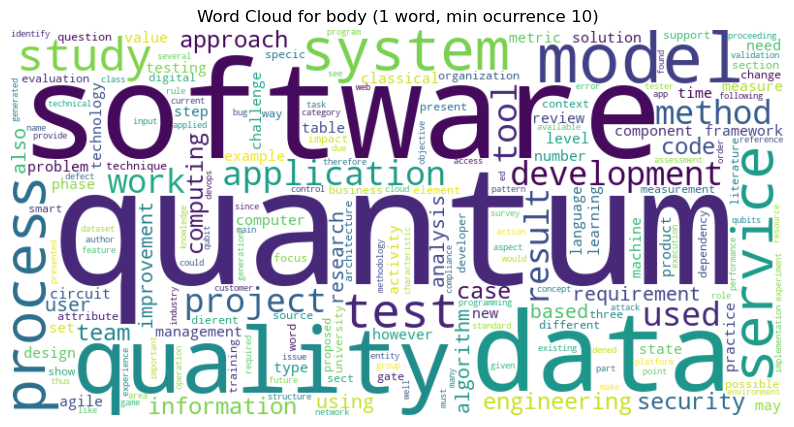

In [21]:
# Word cloud for single word title
scenario = (10, 1)
data, frequencies, frequencies_df = create_data_frecuencies(*scenario)
display(frequencies_df)
create_word_cloud(frequencies, 'Word Cloud for body (1 word, min ocurrence 10)', *scenario)

quantum computing  \
Quantum Computing Platforms- Assessing the Impa...               44.0   
Research on Quality Model for Quantum Simulator...               28.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                0.0   
Some Size and Structure Metrics for Quantum Sof...                0.0   
Quantum Services Generation and Deployment Proc...               20.0   
The Talavera Manifesto for Qua.pdf                                0.0   
Quantum service-oriented computing- current lan...               35.0   
Challenges and opportunities in quantum machine...                0.0   
An exploratory study on the challenges of engin...                0.0   
Math and physics tools for quality quantum prog...               74.0   
Addressing Temporal Variations in Qubit Quality...                0.0   
Software quality issues in quantum information ...               21.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                0.0   
Studying efficacy of traditional software quali...               54.0   

                                                    computing platform  \
Quantum Computing Platforms- Assessing the Impa...                19.0   
Research on Quality Model for Quantum Simulator...                 0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                 0.0   
Some Size and Structure Metrics for Quantum Sof...                 0.0   
Quantum Services Generation and Deployment Proc...                 0.0   
The Talavera Manifesto for Qua.pdf                                 0.0   
Quantum service-oriented computing- current lan...                 0.0   
Challenges and opportunities in quantum machine...                 0.0   
An exploratory study on the challenges of engin...                 0.0   
Math and physics tools for quality quantum prog...                 0.0   
Addressing Temporal Variations in Qubit Quality...                 0.0   
Software quality issues in quantum information ...                 0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                 0.0   
Studying efficacy of traditional software quali...                 0.0   

                                                    sdlc activity  \
Quantum Computing Platforms- Assessing the Impa...           27.0   
Research on Quality Model for Quantum Simulator...            0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...            0.0   
Some Size and Structure Metrics for Quantum Sof...            0.0   
Quantum Services Generation and Deployment Proc...            0.0   
The Talavera Manifesto for Qua.pdf                            0.0   
Quantum service-oriented computing- current lan...            0.0   
Challenges and opportunities in quantum machine...            0.0   
An exploratory study on the challenges of engin...            0.0   
Math and physics tools for quality quantum prog...            0.0   
Addressing Temporal Variations in Qubit Quality...            0.0   
Software quality issues in quantum information ...            0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...            0.0   
Studying efficacy of traditional software quali...            0.0   

                                                    quantum computer  \
Quantum Computing Platforms- Assessing the Impa...              19.0   
Research on Quality Model for Quantum Simulator...               0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...               0.0   
Some Size and Structure Metrics for Quantum Sof...               0.0   
Quantum Services Generation and Deployment Proc...               0.0   
The Talavera Manifesto for Qua.pdf                               0.0   
Quantum service-oriented computing- current lan...              20.0   
Challenges and opportunities in quantum machine...              20.0   
An exploratory study on the challenges of engin...              43.0   
Math and physics tools for quality quantum prog...              25.0   
Addressing Tempor

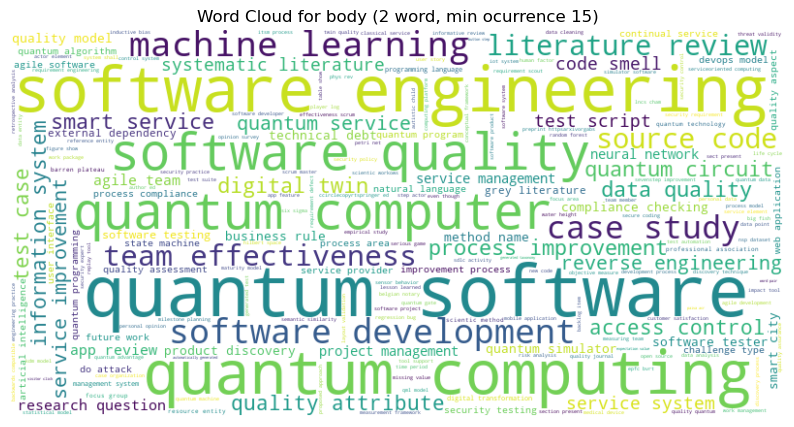

In [23]:
# Word cloud for single word title
scenario = (15, 2)
data, frequencies, frequencies_df = create_data_frecuencies(*scenario)
display(frequencies_df)
create_word_cloud(frequencies, 'Word Cloud for body (2 word, min ocurrence 15)', *scenario)

quantum simulator software  \
Quantum Computing Platforms- Assessing the Impa...                         0.0   
Research on Quality Model for Quantum Simulator...                        24.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                         0.0   
Some Size and Structure Metrics for Quantum Sof...                         0.0   
Quantum Services Generation and Deployment Proc...                         0.0   
The Talavera Manifesto for Qua.pdf                                         0.0   
Quantum service-oriented computing- current lan...                         0.0   
Challenges and opportunities in quantum machine...                         0.0   
An exploratory study on the challenges of engin...                         0.0   
Math and physics tools for quality quantum prog...                         0.0   
Addressing Temporal Variations in Qubit Quality...                         0.0   
Software quality issues in quantum information ...                         0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                         0.0   
Studying efficacy of traditional software quali...                         0.0   

                                                    machine learning algorithm  \
Quantum Computing Platforms- Assessing the Impa...                         0.0   
Research on Quality Model for Quantum Simulator...                         0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                         0.0   
Some Size and Structure Metrics for Quantum Sof...                         0.0   
Quantum Services Generation and Deployment Proc...                        15.0   
The Talavera Manifesto for Qua.pdf                                         0.0   
Quantum service-oriented computing- current lan...                         0.0   
Challenges and opportunities in quantum machine...                         0.0   
An exploratory study on the challenges of engin...                         0.0   
Math and physics tools for quality quantum prog...                         0.0   
Addressing Temporal Variations in Qubit Quality...                         0.0   
Software quality issues in quantum information ...                         0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                         0.0   
Studying efficacy of traditional software quali...                         0.0   

                                                    continual service improvement  \
Quantum Computing Platforms- Assessing the Impa...                            0.0   
Research on Quality Model for Quantum Simulator...                            0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                            0.0   
Some Size and Structure Metrics for Quantum Sof...                            0.0   
Quantum Services Generation and Deployment Proc...                           25.0   
The Talavera Manifesto for Qua.pdf                                            0.0   
Quantum service-oriented computing- current lan...                            0.0   
Challenges and opportunities in quantum machine...                            0.0   
An exploratory study on the challenges of engin...                            0.0   
Math and physics tools for quality quantum prog...                           22.0   
Addressing Temporal Variations in Qubit Quality...                            0.0   
Software quality issues in quantum information ...                            0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                            0.0   
Studying efficacy of traditional software quali...                            0.0   

                                                    systematic literature review  \
Quantum Computing Platforms- Assessing the Impa...                           0.0   
Research on Quality Model for Quantum Simulator...                           0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...            

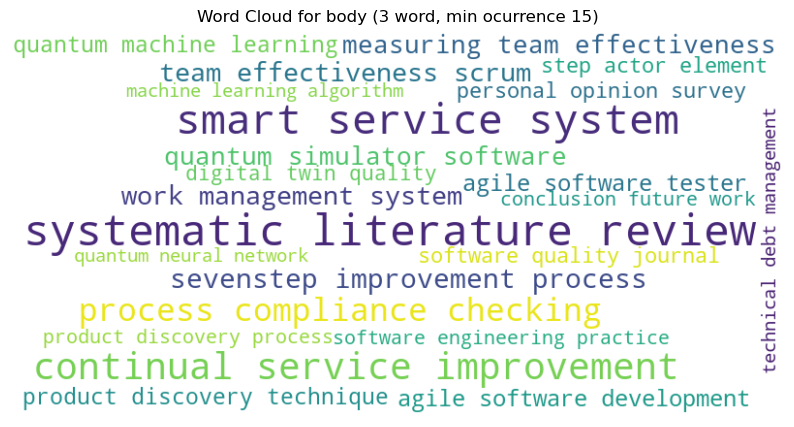

In [25]:
# Word cloud for single word title
scenario = (15, 3)
data, frequencies, frequencies_df = create_data_frecuencies(*scenario)
display(frequencies_df)
create_word_cloud(frequencies, 'Word Cloud for body (3 word, min ocurrence 15)', *scenario)

quality assurance digital twin  \
Quantum Computing Platforms- Assessing the Impa...                             0.0   
Research on Quality Model for Quantum Simulator...                             0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                             0.0   
Some Size and Structure Metrics for Quantum Sof...                             0.0   
Quantum Services Generation and Deployment Proc...                            10.0   
The Talavera Manifesto for Qua.pdf                                             0.0   
Quantum service-oriented computing- current lan...                             0.0   
Challenges and opportunities in quantum machine...                             0.0   
An exploratory study on the challenges of engin...                             0.0   
Math and physics tools for quality quantum prog...                             0.0   
Addressing Temporal Variations in Qubit Quality...                             0.0   
Software quality issues in quantum information ...                             0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                             0.0   
Studying efficacy of traditional software quali...                             0.0   

                                                    continual service improvement systematic  \
Quantum Computing Platforms- Assessing the Impa...                                       0.0   
Research on Quality Model for Quantum Simulator...                                       0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                                       0.0   
Some Size and Structure Metrics for Quantum Sof...                                       0.0   
Quantum Services Generation and Deployment Proc...                                      10.0   
The Talavera Manifesto for Qua.pdf                                                       0.0   
Quantum service-oriented computing- current lan...                                       0.0   
Challenges and opportunities in quantum machine...                                       0.0   
An exploratory study on the challenges of engin...                                       0.0   
Math and physics tools for quality quantum prog...                                       0.0   
Addressing Temporal Variations in Qubit Quality...                                       0.0   
Software quality issues in quantum information ...                                       0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...                                       0.0   
Studying efficacy of traditional software quali...                                       0.0   

                                                    service improvement systematic literature  \
Quantum Computing Platforms- Assessing the Impa...                                        0.0   
Research on Quality Model for Quantum Simulator...                                        0.0   
Cruz-Lemus et al. - 2021 - Towards a Set of Met...                                        0.0   
Some Size and Structure Metrics for Quantum Sof...                                        0.0   
Quantum Services Generation and Deployment Proc...                                       10.0   
The Talavera Manifesto for Qua.pdf                                                        0.0   
Quantum service-oriented computing- current lan...                                        0.0   
Challenges and opportunities in quantum machine...                                        0.0   
An exploratory study on the challenges of engin...                                        0.0   
Math and physics tools for quality quantum prog...                                        0.0   
Addressing Temporal Variations in Qubit Quality...                                        0.0   
Software quality issues in quantum information ...                                        0.0   
Elsharkawy et al. - 2023 - Challenges in HPCQC ...         

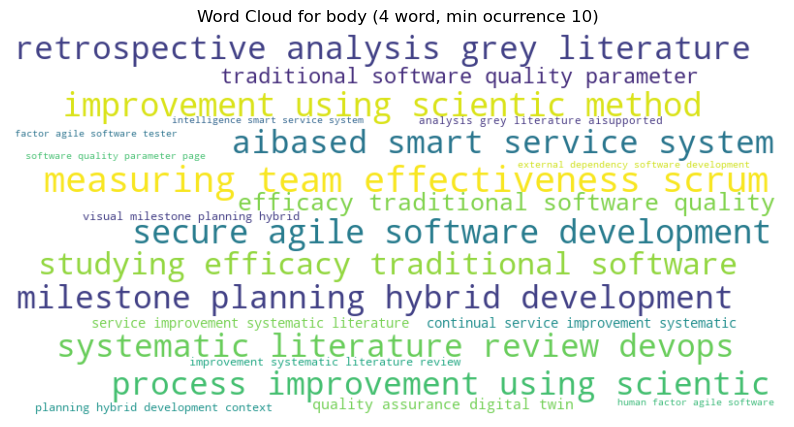

In [27]:
# Word cloud for single word title
scenario = (10, 4)
data, frequencies, frequencies_df = create_data_frecuencies(*scenario)
display(frequencies_df)
create_word_cloud(frequencies, 'Word Cloud for body (4 word, min ocurrence 10)', *scenario)

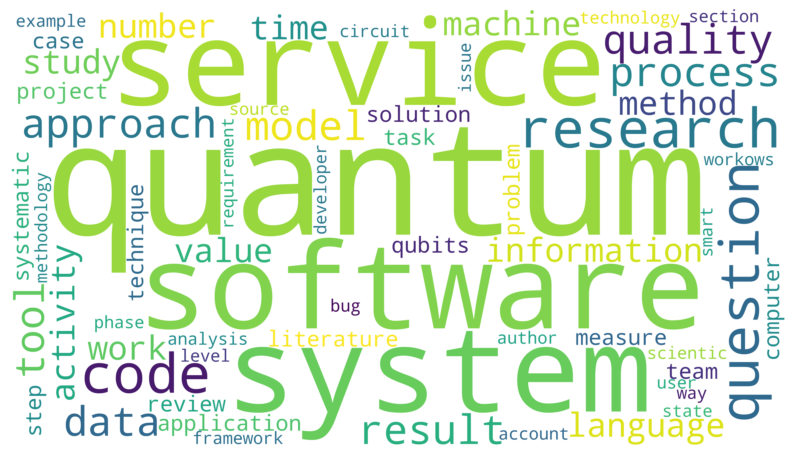

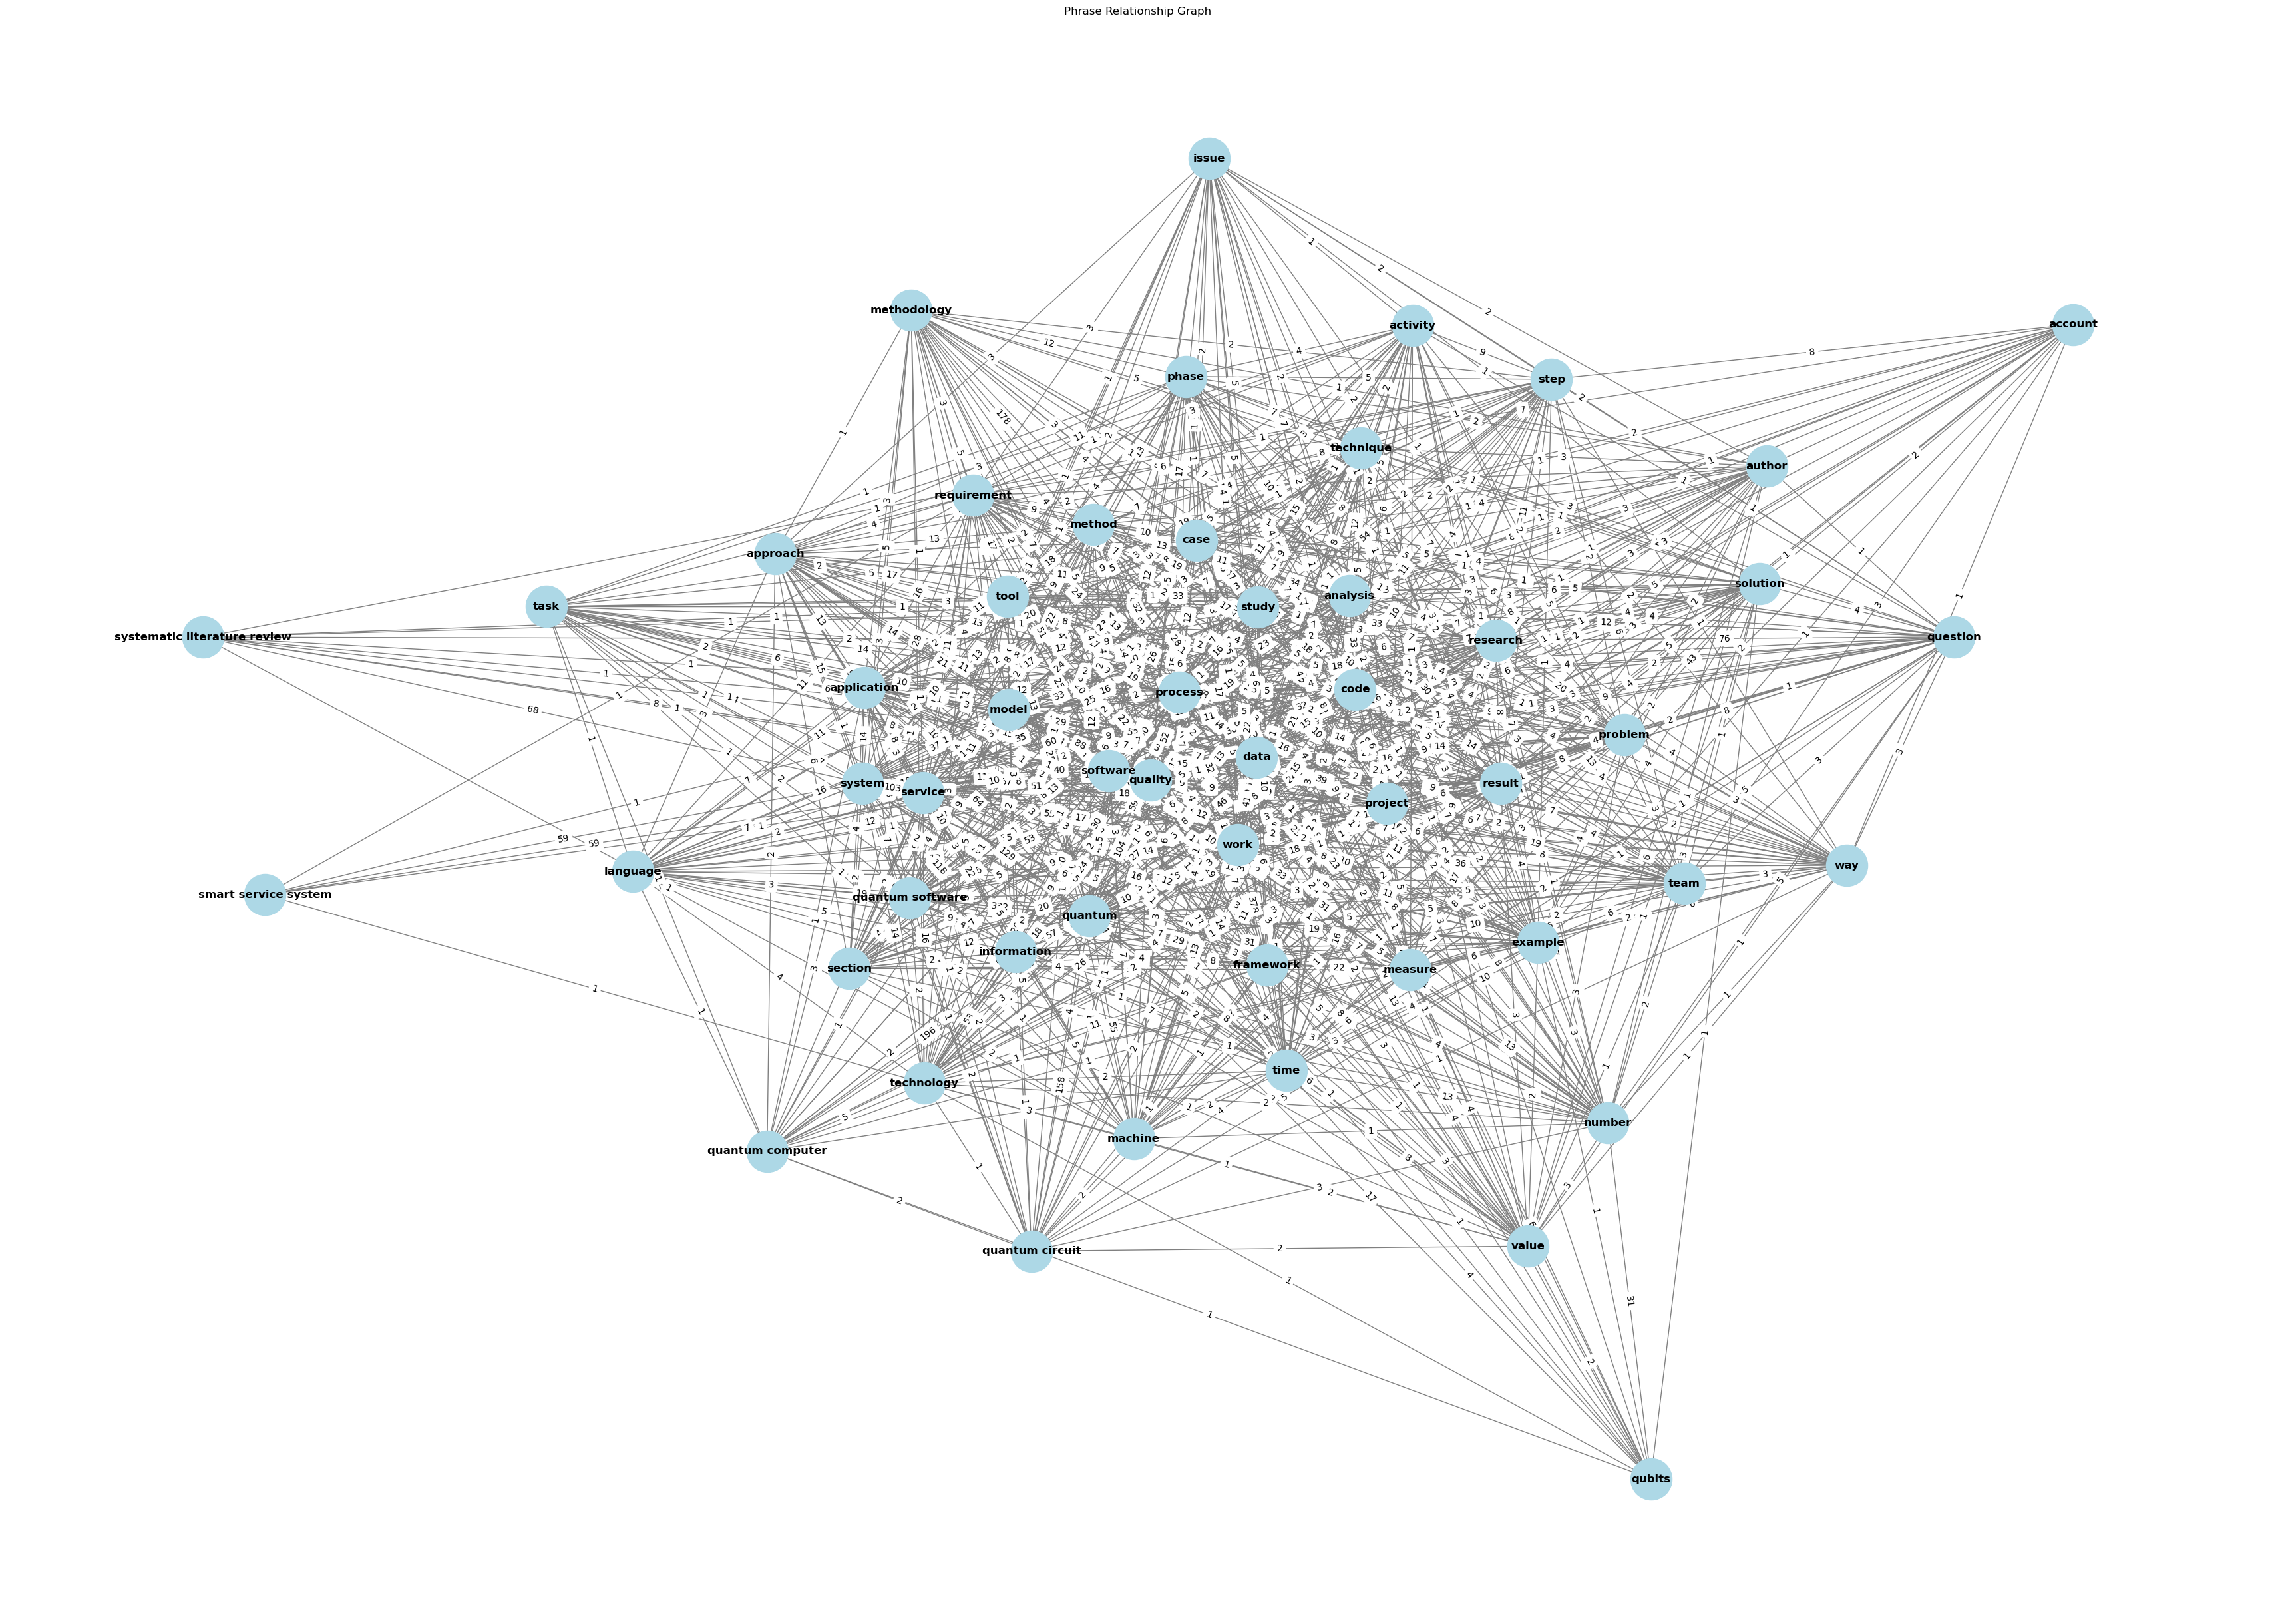

In [17]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.chunk import RegexpParser
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from itertools import combinations

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

def extract_phrases(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    # grammar = r"""
    #     NP: {<DT|JJ|NN.*>+}
    # """

    grammar = r"""
        NP: {<DT>?<JJ>*<NN.*>+}  # Noun Phrase without Numbers
            {<JJ>*<NN.*><IN><NN.*>+}  # Noun Phrase with Preposition
            {<JJ>*<NN.*>}  # Noun Phrase without determiner
            {<NNP>+}  # Proper Nouns
            {<DT>?<JJ>*<NN.*>+<CC><JJ>*<NN.*>+}  # Noun Phrases joined by Conjunctions
    """
    
    chunker = RegexpParser(grammar)
    result = chunker.parse(tagged)
    
    phrases = []
    for subtree in result.subtrees():
        if subtree.label() == 'NP':
            phrases.append(' '.join(word for word, pos in subtree.leaves()))

    return phrases

# The rest of the code remains the same
def generate_graph(phrases, threshold=2):
    phrase_counter = Counter(phrases)
    common_phrases = [phrase for phrase, count in phrase_counter.items() if count >= threshold]
    generate_word_cloud(phrase_counter)
    
    G = nx.Graph()
    G.add_nodes_from(common_phrases)
    
    for phrase1, phrase2 in combinations(common_phrases, 2):
        weight = sum(1 for p in phrases if phrase1 in p and phrase2 in p)
        if weight > 0:
            G.add_edge(phrase1, phrase2, weight=weight)
    
    return G

def visualize_graph(G):
    # edges,weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    pos = nx.spring_layout(G)
    plt.figure(figsize=(34, 24))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', edge_color='gray', edge_cmap=plt.cm.Grays)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Phrase Relationship Graph")
    plt.axis('off')
    plt.savefig('relations.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_word_cloud(phrase_counter):
    common_phrases = [phrase for phrase, count in phrase_counter.most_common(60)]
    
    wordcloud = WordCloud(width = 3840, height = 2160, background_color ='white').generate(' '.join(common_phrases))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('relations-cloud.png', dpi=300, bbox_inches='tight')
    plt.show()

# text = """
# The artificial intelligence revolution is transforming various industries. 
# Machine learning algorithms are becoming more sophisticated, enabling AI systems to perform complex tasks. 
# Deep learning, a subset of machine learning, has shown remarkable results in image and speech recognition. 
# Natural language processing, another AI technology, is improving human-computer interactions. 
# AI applications are found in healthcare, finance, and autonomous vehicles. 
# The ethical implications of artificial intelligence are a growing concern among researchers and policymakers.
# """

phrases = extract_phrases(' '.join(df['full_text']))
graph = generate_graph(phrases, threshold=25)
visualize_graph(graph)